In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
cl_kadij = np.loadtxt("Cl_KadIJ.txt")
cl_lobith = np.loadtxt("Cl_Lobith.txt")
afvoer_lobith = np.loadtxt("afvoer_Lobith.txt")
stand_hvh = np.loadtxt("stand_HvH.txt")

In [3]:
print("shape van cl_kadij:", np.shape(cl_kadij))
print("shape van cl_lobith:", np.shape(cl_lobith))
print("shape van afvoer_lobith:", np.shape(afvoer_lobith))
print("shape van stand_hvh:", np.shape(stand_hvh))

shape van cl_kadij: (259633, 3)
shape van cl_lobith: (259633, 6)
shape van afvoer_lobith: (259633, 6)
shape van stand_hvh: (259633, 3)


In [4]:
print("eerste elementen:")
print(cl_kadij[1,:])
print(cl_lobith[1,:])
print(afvoer_lobith[1,:])
print(stand_hvh[1,:])

eerste elementen:
[  1.98201010e+07   1.00000000e+04   9.99999000e+02]
[  1.98201010e+07   1.00000000e+04   9.99999000e+02   7.67518000e+01
   9.99999000e+02   0.00000000e+00]
[  1.98201010e+07   1.00000000e+04   9.99999000e+02   9.99999000e+02
   9.99999000e+02   9.90000000e+01]
[  1.98201010e+07   1.00000000e+04  -2.80000000e+01]


In [5]:
usable_indices = (cl_kadij[:,2] != 999.999) & (cl_lobith[:,3] != 999.999) & (afvoer_lobith[:,3] != 999.999) & (stand_hvh[:,2] != 999.999)
print("Aantal metingen aanwezig in allen:", np.sum(usable_indices))

Aantal metingen aanwezig in allen: 225964


In [6]:
#check of data inderdaad allemaal voor zelfde date-time bij zelfde index staat:
if (np.sum(cl_kadij[:,:2] != cl_lobith[:,:2]) | np.sum(cl_lobith[:,:2] != afvoer_lobith[:,:2]) | np.sum(afvoer_lobith[:,:2] != stand_hvh[:,:2])):
    print("something is of")

In [7]:
#time_data = (cl_kadij[:,:2])[usable_indices]
time_data = ((np.loadtxt("Cl_KadIJ.txt",dtype=str))[:,:2])[usable_indices]
cl_kadij_data = (cl_kadij[:,2])[usable_indices]
cl_lobith_data = (cl_lobith[:,3])[usable_indices]
afvoer_lobith_data = (afvoer_lobith[:,3])[usable_indices]
stand_hvh_data = (stand_hvh[:,2])[usable_indices]
print("shapes:", np.shape(time_data), np.shape(cl_kadij_data), np.shape(cl_lobith_data), np.shape(afvoer_lobith_data), np.shape(stand_hvh_data))

shapes: (225964, 2) (225964,) (225964,) (225964,) (225964,)


In [8]:
#convert time_data into datetime format (this will take a while, several minutes!)
from datetime import datetime
datetime_data = np.array([]);
for row in range(len(time_data)):
    as_datetime = datetime.strptime(time_data[row,0] + " " + time_data[row,1], '%Y%m%d %H%M%S')
    datetime_data = np.append(datetime_data,as_datetime)

# Dagvoorspelling

Train een model om uit de data van een dag geleden (0:00 uur), de chloride bij Krimpen aan de IJssel te voorspellen.

Notes:
- modellen zijn nu simpel overgenomen van example Fedor, dus dit kan waarschijnlijk nog geoptimaliseerd worden
- eerste model neemt als input alleen afvoer en cl bij Lobith, en stand bij HvH
- tweede model neemt als vierde input parameter ook het cl van Krimpen ad IJssel van gisteren mee 
- data bevat gaten (en geen stuk lang genoeg om enkel dat te gebruiken), gaten zijn voor nu gewoon verwijderd, dit betekent vermoedelijk dat de voorspelling op data direct na een gat slechter is. 

In [9]:
indices = (time_data[:,1] == "000000")
output_raw = cl_kadij_data[indices]
input_raw = np.transpose(np.vstack((cl_lobith_data, afvoer_lobith_data, stand_hvh_data)))
input_raw = input_raw[indices]
datetime_raw = datetime_data[indices]
print("input shape:", np.shape(input_raw))
print("output shape:", np.shape(output_raw))
print("datetime shape:", np.shape(datetime_raw))

input shape: (9445, 3)
output shape: (9445,)
datetime shape: (9445,)


In [25]:
#second option: also take the previous value into account 
input2_raw = np.transpose(np.vstack((cl_kadij_data, cl_lobith_data, afvoer_lobith_data, stand_hvh_data)));
input2_raw = input2_raw[indices]
print("input 2 shape:", np.shape(input2_raw))

input 2 shape: (9445, 4)


In [26]:
#normalize the data
import sklearn.preprocessing

output_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
output_scaler.fit(output_raw.reshape(-1,1))
print("min output:", output_scaler.data_min_)
print("range output:", output_scaler.data_range_)
output_scaled = output_scaler.transform(output_raw.reshape(-1,1))

input_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
input_scaler.fit(input_raw)
print("min input:", input_scaler.data_min_)
print("range input:", input_scaler.data_range_)
input_scaled = input_scaler.transform(input_raw)

input2_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
input2_scaler.fit(input2_raw)
print("min input 2:", input2_scaler.data_min_)
print("range input 2:", input2_scaler.data_range_)
input2_scaled = input2_scaler.transform(input2_raw)

min output: [ 22.]
range output: [ 2247.]
min input: [  35.8669  789.605  -136.    ]
range input: [   384.1331  11095.395     374.    ]
min input 2: [  22.       35.8669  789.605  -136.    ]
range input 2: [  2247.        384.1331  11095.395     374.    ]


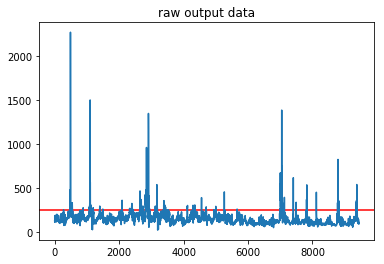

In [11]:
plt.axhline(y=250,color='red')
plt.title("raw output data")
plt.plot(output_raw);

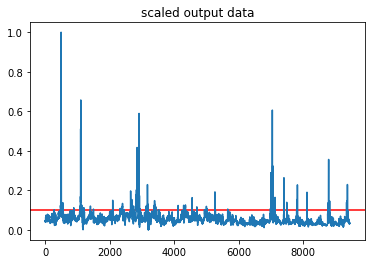

In [12]:
yline = output_scaler.transform(np.ones((1,1)) * 250)
plt.axhline(y=yline,color='red')
plt.title("scaled output data")
plt.plot(output_scaled);

In [13]:
#note that there may be gaps, so let's find those if they exist
from datetime import timedelta
datetime_diff = datetime_raw[1:] - datetime_raw[:-1]
single_day_diff = datetime_diff == timedelta(days=1)
print("detected", np.sum(~single_day_diff), "gaps")
np.where(single_day_diff == False)

detected 97 gaps


(array([  39,  179,  276,  284,  286,  324,  338,  532,  836,  843, 1141,
        1152, 1171, 1189, 1218, 1345, 1458, 1495, 1723, 1787, 1809, 1837,
        1846, 1883, 1929, 2043, 2068, 2582, 2608, 2707, 2729, 2737, 2771,
        2773, 2775, 2780, 2810, 2812, 2843, 2870, 2929, 2951, 3519, 3525,
        3528, 3667, 3699, 3751, 3760, 3908, 4140, 4173, 4624, 5930, 5936,
        5943, 5955, 6073, 6083, 6085, 6093, 6096, 6109, 6186, 6191, 6281,
        6326, 6348, 6379, 6415, 6513, 6587, 6647, 6671, 6683, 6697, 6698,
        6706, 7372, 7526, 7641, 7708, 7860, 7896, 7983, 8000, 8174, 8187,
        8307, 8440, 8498, 9104, 9117, 9123, 9152, 9173, 9442], dtype=int64),)

In [28]:
#there is no long continues part, so just delete the incomplete data
input_full = input_scaled[np.append(single_day_diff,np.array([False]))]
input2_full = input2_scaled[np.append(single_day_diff,np.array([False]))]
output_full = output_scaled[np.insert(single_day_diff,0,False)]
print("final input shape:", np.shape(input_full))
print("final output shape:", np.shape(output_full))
print("final input 2 shape:", np.shape(input2_full))

final input shape: (9347, 3)
final output shape: (9347, 1)
final input 2 shape: (9347, 4)


In [29]:
#just split the data in three equal parts for training, test and validation
size = int(len(input_full) / 3)
input_train = input_full[:size,:]
input_test = input_full[size:2*size,:]
input_validate = input_full[2*size:,:]
output_train = output_full[:size,:]
output_test = output_full[size:2*size,:]
output_validate = output_full[2*size:,:]
input2_train = input2_full[:size,:]
input2_test = input2_full[size:2*size,:]
input2_validate = input2_full[2*size:,:]


In [16]:
keras.callbacks.TensorBoard(
    log_dir='./logs', 
    histogram_freq=1, 
    batch_size=32, 
    write_graph=True, 
    write_grads=True, 
    write_images=True, 
    embeddings_freq=0, 
    embeddings_layer_names=None, 
    embeddings_metadata=None
);

In [17]:
model = keras.models.Sequential()
layer = keras.layers.LSTM(4,input_shape=(None,len(input_full[0])))
model.add(layer)
layer = keras.layers.Dense(1)
model.add(layer)
model.compile(loss='mean_squared_error', optimizer='adam')

In [31]:
model2 = keras.models.Sequential()
layer = keras.layers.LSTM(4,input_shape=(None, len(input2_full[0])))
model2.add(layer)
layer = keras.layers.Dense(1)
model2.add(layer)
model2.compile(loss='mean_squared_error', optimizer='adam')

In [33]:
print("first model:")
model.summary()
print("\nsecond model:")
model2.summary()

first model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 128       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________

second model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 144       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(input_train[:,np.newaxis,:], output_train, epochs=2, batch_size=1, verbose=2)

Epoch 1/2
5s - loss: 0.0015
Epoch 2/2
6s - loss: 0.0014


In [34]:
history2 = model2.fit(input2_train[:,np.newaxis,:], output_train, epochs=2, batch_size=1, verbose=2)

Epoch 1/2
5s - loss: 0.0014
Epoch 2/2
5s - loss: 0.0011


In [35]:
output_model = model.predict(input_test[:,np.newaxis,:])
output_model2 = model2.predict(input2_test[:,np.newaxis,:])

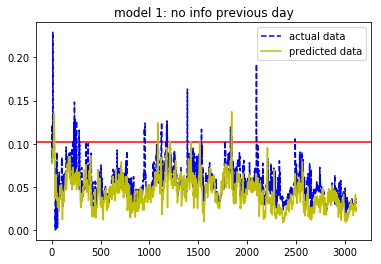

In [51]:
plt.axhline(y=yline,color='red')
plt.plot(output_test,'b--',label='actual data')
plt.plot(output_model, 'y',label='predicted data')
plt.title("model 1: no info previous day")
plt.legend();

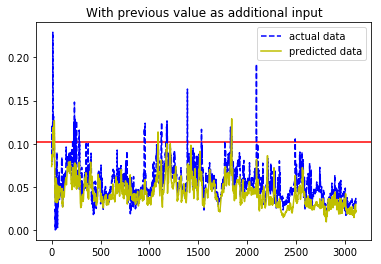

In [38]:
plt.axhline(y=yline,color='red')
plt.plot(output_test,'b--',label='actual data')
plt.plot(output_model2, 'y',label='predicted data')
plt.title("With previous value as additional input")
plt.title("model 2: with previous value as additional input")
plt.legend();

length of output: 3115


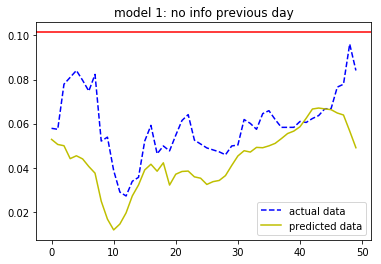

In [50]:
print("length of output:",len(output_model))

#kleiner stuk data helpt voor zichtbaarheid, verander selection om andere data the bekijken
selection = np.s_[100:150]
plt.axhline(y=yline,color='red')
plt.plot(output_test[selection],'b--',label='actual data')
plt.plot(output_model[selection], 'y',label='predicted data')
plt.title("model 1: no info previous day")
plt.legend();

length of output: 3115


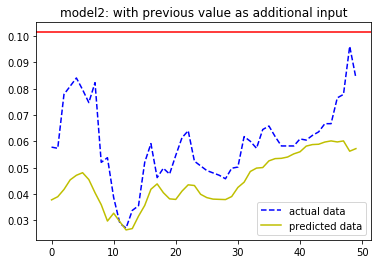

In [49]:
print("length of output:",len(output_model))

#kleiner stuk data helpt voor zichtbaarheid, verander selection om andere data the bekijken
selection = np.s_[100:150]
plt.axhline(y=yline,color='red')
plt.plot(output_test[selection],'b--',label='actual data')
plt.plot(output_model2[selection], 'y',label='predicted data')
plt.title("model 2: with previous value as additional input")
plt.legend();

In [55]:
errors = np.abs(output_test - output_model)
MSE = errors ** 2
print("highest absolute SE:",np.max(MSE))
print("absolute MSE:",np.average(MSE))

actual_errors = errors * output_scaler.data_range_ + output_scaler.data_min_
MSE_actual = actual_errors ** 2
print("non-normalized highest absolute SE:",np.max(MSE_actual))
print("non-normalized absolute MSE:",np.average(MSE_actual))

rel_errors = actual_errors / (output_test*output_scaler.data_range_ + output_scaler.data_min_)
print("highest relative error:",np.max(rel_errors))
print("average relative error:",np.average(rel_errors))


highest absolute SE: 0.021007195588
absolute MSE: 0.000353092516738
non-normalized highest absolute SE: 120879.308349
non-normalized absolute MSE: 3641.50340045
highest relative error: 6.32123621258
average relative error: 0.381583266795


In [56]:
errors = np.abs(output_test - output_model2)
MSE2 = errors ** 2
print("highest absolute SE:",np.max(MSE2))
print("absolute MSE:",np.average(MSE2))

actual_errors = errors * output_scaler.data_range_ + output_scaler.data_min_
MSE_actual = actual_errors ** 2
print("non-normalized highest absolute SE:",np.max(MSE_actual))
print("non-normalized absolute MSE:",np.average(MSE_actual))

rel_errors = actual_errors / (output_test*output_scaler.data_range_ + output_scaler.data_min_)
print("highest relative error:",np.max(rel_errors))
print("average relative error:",np.average(rel_errors))


highest absolute SE: 0.0184665042205
absolute MSE: 0.00029160248791
non-normalized highest absolute SE: 107156.868448
non-normalized absolute MSE: 3266.94966708
highest relative error: 6.35844130519
average relative error: 0.372168725009


In [61]:
#vergelijk met basisvoorspelling, zelfde zoutgehalte als gisteren:
basic_error = np.abs(output_test[1:] - output_test[:-1])
MSE_basic = np.average(basic_error ** 2)
print("absolute MSE basic prediction method:", MSE_basic)
print("Prediction skill model 1:", 1 - np.average(MSE) / MSE_basic)
print("Prediction skill model 2:", 1 - np.average(MSE2) / MSE_basic)
print("Conclusion: we are doing really badly")

absolute MSE basic prediction method: 8.35359818557e-05
Prediction skill model 1: -3.22683146704
Prediction skill model 2: -2.49074113253
Conclusion: we are doing really badly


# Uurvoorspelling

Voorspel de chloride m.b.v. de uurwaarden, 1 uur vooruit

In [ ]:

cl_kadij_data = (cl_kadij[:,2])[usable_indices]
cl_lobith_data = (cl_lobith[:,3])[usable_indices]
afvoer_lobith_data = (afvoer_lobith[:,3])[usable_indices]
stand_hvh_data 
datatime_data